In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import numpy as np

import os
from matplotlib import pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
# from create_foreground_background import fg_bg_data,fg_data
# from mini_inception import inception_net
# from resnet import ResNet18,ResNet34,ResNet50

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}

background_classes = {'cat', 'deer', 'dog', 'frog','horse','ship', 'truck'}

# print(type(foreground_classes))

In [5]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [6]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])
      label = foreground_label[fg_idx]  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [7]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)

In [8]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [9]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [10]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import numpy as np


device = 'cuda' if torch.cuda.is_available() else 'cpu'


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(27, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2],num_classes=num_classes)
# def ResNet34(num_classes):
#     return ResNet(BasicBlock, [3,4,6,3],num_classes=num_classes)
# def ResNet50(num_classes):
#     return ResNet(Bottleneck, [3,4,6,3],num_classes=num_classes)

In [40]:
net = ResNet18(9*3)
net = net.to("cuda").double()
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)



In [41]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, data in enumerate(train_loader):
        inputs , labels , fore_idx = data
        inputs = inputs.double()
        # zero the parameter gradients
        # print(inputs.shape)
        inputs = torch.reshape(inputs,(batch,9*3,32,32))
        # print(inputs.shape)
        inputs , labels , fore_idx = inputs.to("cuda") , labels.to("cuda"), fore_idx.to("cuda")
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return train_loss/(batch_idx+1)



In [42]:
# Commented out IPython magic to ensure Python compatibility.
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            inputs , labels , fore_idx = data
            inputs = inputs.double()
            # zero the parameter gradients
            # print(inputs.shape)
            inputs = torch.reshape(inputs,(batch,9*3,32,32))
            # print(inputs.shape)
            inputs , labels , fore_idx = inputs.to("cuda") , labels.to("cuda"), fore_idx.to("cuda")
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Save checkpoint.
    # acc = (100.0)*correct/total
    # if acc > best_acc:
    #     print('Saving..')
    #     state = {
    #         'net': net.state_dict(),
    #         'acc': acc,
    #         'epoch': epoch,
    #     }
    #     if not os.path.isdir('checkpoint'):
    #         os.mkdir('checkpoint')
    #     torch.save(state, './checkpoint/ckpt.pth')
    #     best_acc = acc
    return test_loss/(batch_idx+1)



In [43]:
 best_acc = 0 
start_epoch =0
tr_loss = []
ts_loss = []
for epoch in range(start_epoch, start_epoch+50):
    tr_loss.append(train(epoch))
    ts_loss.append(test(epoch))



Epoch: 0
119 5000 Loss: 1.160 | Acc: 36.587% (10976/30000)
39 1000 Loss: 1.131 | Acc: 36.230% (3623/10000)

Epoch: 1
119 5000 Loss: 1.083 | Acc: 42.327% (12698/30000)
39 1000 Loss: 1.129 | Acc: 40.720% (4072/10000)

Epoch: 2
119 5000 Loss: 1.056 | Acc: 45.540% (13662/30000)
39 1000 Loss: 1.217 | Acc: 37.740% (3774/10000)

Epoch: 3
119 5000 Loss: 1.023 | Acc: 48.097% (14429/30000)
39 1000 Loss: 1.074 | Acc: 43.320% (4332/10000)

Epoch: 4
119 5000 Loss: 0.983 | Acc: 51.707% (15512/30000)
39 1000 Loss: 1.159 | Acc: 40.120% (4012/10000)

Epoch: 5
119 5000 Loss: 0.938 | Acc: 55.010% (16503/30000)
39 1000 Loss: 1.154 | Acc: 42.120% (4212/10000)

Epoch: 6
119 5000 Loss: 0.870 | Acc: 59.570% (17871/30000)
39 1000 Loss: 1.270 | Acc: 41.000% (4100/10000)

Epoch: 7
119 5000 Loss: 0.775 | Acc: 65.587% (19676/30000)
39 1000 Loss: 1.335 | Acc: 40.190% (4019/10000)

Epoch: 8
119 5000 Loss: 0.672 | Acc: 71.420% (21426/30000)
39 1000 Loss: 1.368 | Acc: 40.910% (4091/10000)

Epoch: 9
119 5000 Loss: 0.5

KeyboardInterrupt: ignored

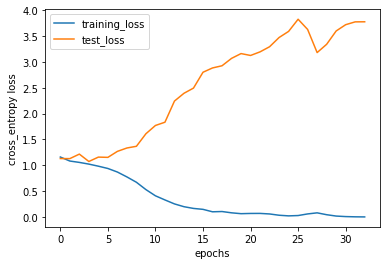

In [46]:

# model = ResNet34(3)
# #model = inception_net(3,3)
# model = model.to(device)
# if device == 'cuda':
#     model = torch.nn.DataParallel(model)
#     cudnn.benchmark = True


# checkpoint = torch.load('./checkpoint/ckpt.pth')
# model.load_state_dict(checkpoint['net'])


# epoch = checkpoint['epoch']
# test_acc = checkpoint['acc']

plt.plot(tr_loss,label='training_loss')
plt.plot(ts_loss,label = 'test_loss')
plt.xlabel("epochs")
plt.ylabel("cross_entropy loss")
plt.legend()

# test_acc